<a href="https://colab.research.google.com/github/VViswaPrahlad/Blood/blob/main/BloodStain_Identification_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# Colab Requirements
!pip install spectral
import spectral
from google.colab import drive, files
drive.mount('/content/drive')

## Basics
import gc
gc.collect()
import warnings
warnings.filterwarnings('ignore')
import time
import numpy
import numpy as np
import pandas as pd
from PIL import Image
from operator import truediv
import scipy.io as sio
import os
import seaborn as sns

## Plotting
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline

## Sklearn
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

## Dimensionality Reduction Methods
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA, SparsePCA, TruncatedSVD

## Deep Learning Model
!pip install keras h5py  # Ensure Keras and h5py are installed
import keras
import h5py
from keras.layers import Input, Conv2D, Conv3D, Flatten, Dense, Reshape, Dropout
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical  # Replace np_utils
import spectral.io.envi as envi

# Notes:
# - `np_utils` has been replaced with `to_categorical` from `tensorflow.keras.utils`.
# - Ensure TensorFlow and Keras versions are compatible. Update using `!pip install --upgrade tensorflow keras` if needed.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
## Mounting Google Drive
path='/content/drive/MyDrive/HyperBlood/'

In [52]:
## Get HSI Data and Ground Truths
## Get HSI Data
def get_data(name,remove_bands=True,clean=True, path=path):
    """
    Input: name: name; remove_bands: if True, noisy bands are removed (leaving 113 bands)
    clean: if True, remove damaged line
    Output: data, wavelenghts as numpy arrays (float32)
    """
    name = convert_name(name)
    filename = "{}data/{}".format(path,name)
    hsimage = envi.open('{}.hdr'.format(filename),'{}.float'.format(filename))
    wavs = np.asarray(hsimage.bands.centers)
    data = np.asarray(hsimage[:,:,:],dtype=np.float32)
    #removal of damaged sensor line
    if clean and name!='F_2k':
        data = np.delete(data,445,0)
    if not remove_bands:
        return data,wavs
    return data[:,:,get_good_indices(name)],wavs[get_good_indices(name)]

## Get Ground Truths
def get_anno(name,remove_uncertain_blood=True,clean=True, path=path):
    """
    Returns annotation (GT) for data files as 2D int numpy array
    Classes: 0 - background; 1 - blood; 2 - ketchup; 3 - artificial blood; 4 - beetroot juice
    5 - poster paint; 6 - tomato concentrate; 7 - acrtylic paint; 8 - uncertain blood;
    Input: name: name; clean: if True, remove damaged line;
    remove_uncertain_blood: if True, removes class 8
    Output: annotation as numpy 2D array
    """
    name = convert_name(name)
    filename = "{}anno/{}".format(path,name)
    anno = np.load(filename+'.npz')['gt']
    #removal of damaged sensor line
    if clean and name!='F_2k':
        anno = np.delete(anno,445,0)
    #remove uncertain blood + technical classes
    if remove_uncertain_blood:
        anno[anno>7]=0
    else:
        anno[anno>8]=0
    return anno


def blood_loader(path, name):
    """
    returns data and annotation, removing classes that are not present in all images
    Input: path: data path; name: image name
    Output:img: data cube; gt: annotation with correct classes;
    rgb_bands: three bands used for rgb visualisation
    ignored_labels: labels that should be ignored [0 for background]
    label_values: class labels
    """
    img = np.asarray(get_data(name, path=path)[0], dtype='float32')
    gt = get_anno(name, path=path).astype('uint8')
    # remove beetroot juice (is only on frames images so in our
    # classification experiments we removed it from pictures)
    gt = np.where(gt == 4, 0, gt)
    # renumbering after removing beetroot juice
    for element in [5, 6, 7]:
        gt = np.where(gt == element, element - 1, gt)
    label_values = ["unclassified",
                    "blood",
                    "ketchup",
                    "artificial blood",
                    "poster paint",
                    "tomato concentrate",
                    "acrylic paint"]
    rgb_bands, ignored_labels = (47, 31, 15), [0]
    return img, gt, rgb_bands, ignored_labels, label_values

In [53]:
def convert_name(name):
    """
    Ensures that the name is in the filename format
    Parameters: name: name
    Output: cleaned name
    """
    name = name.replace('(','_')
    name = name.replace(')','')
    return name

def get_good_indices(name=None):
    """
    Input: name: name
    Output: numpy array of good indices
    """
    name = convert_name(name)
    if name!='F_2k':
        indices = np.arange(128)
        indices = indices[5:-7]
    else:
        indices = np.arange(116)
    indices=np.delete(indices,[43,44,45])
    return indices

In [54]:
## Load HSI Dataset
def LoadHSIData(method):
    ## List of HSI Dataasets
    HSI_list = ['A_1.hdr', 'B_1.hdr', 'C_1.hdr', 'D_1.hdr', 'E_1.hdr', 'E_7.hdr',
                'E_21.hdr', 'F_1.hdr.hdr', 'F_1a.hdr', 'F_1s.hdr', 'F_2.hdr',
                'F_2k.hdr', 'F_7.hdr', 'F_21.hdr']
    for i in range(len(HSI_list)):
        file_name = HSI_list[i].split('.')[0]
        data_path = os.path.join(os.getcwd(),'/content/drive/MyDrive/DeepHyperBlood/Datasets/HyperBlood/data'+str(file_name))
        # print(data_path)
        if os.path.exists(data_path) == False:
            # print("Data file from %s to %s" % (HSI_list[i], data_path))
            # #urllib.request.urlretrieve(url=HSI_url[i], filename=data_path)
            print(str(file_name)+" is Successfully Found")
        else:
            print(str(file_name) + " already exist")
    data_path = os.path.join(os.getcwd(),'/content/drive/MyDrive/DeepHyperBlood/Datasets/HyperBlood/data')
    data_path1 = os.path.join(os.getcwd(),'/content/drive/MyDrive/DeepHyperBlood/Datasets/HyperBlood/anno')
    if method == 'A_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'B_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'C_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'D_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'E_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'E_7':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'E_21':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_1a':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_1s':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_2':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_2k':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_7':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_21':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    # remove beetroot juice (is only on frames images so in our
    # classification experiments we removed it from pictures)
    # GT = np.where(GT == 4, 0, GT)
    # # renumbering after removing beetroot juice
    # for element in [5, 6, 7]:
    #     GT = np.where(GT == element, element - 1, GT)
    # rgb_bands, ignored_labels = (47, 31, 15), [0]
    return HSI, GT

In [55]:
## Train/Test Split
def TrTeSplit(HSI, GT, testRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size = testRatio,
                                        random_state = randomState,
                                        stratify = GT)
    return Tr, Te, TrC, TeC

In [56]:
## Dimension Reduction
def DLMethod(method, HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    if method == 'PCA': ## PCA
        pca = PCA(n_components = NC, whiten = True)
        RHSI = pca.fit_transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'iPCA': ## Incremental PCA
        n_batches = 256
        inc_pca = IncrementalPCA(n_components = NC)
        for X_batch in np.array_split(RHSI, n_batches):
          inc_pca.partial_fit(X_batch)
        X_ipca = inc_pca.transform(RHSI)
        RHSI = np.reshape(X_ipca, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'KPCA': ## Kernel PCA
        kpca = KernelPCA(kernel = "rbf", n_components = NC, gamma = None,
                         fit_inverse_transform = True, random_state = 2019,
                         n_jobs=1)
        kpca.fit(RHSI)
        RHSI = kpca.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'SPCA': ## Sparse PCA
        sparsepca = SparsePCA(n_components = NC, alpha=0.0001, random_state=2019, n_jobs=-1)
        sparsepca.fit(RHSI)
        RHSI = sparsepca.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'SVD': ## Singular Value Decomposition
        SVD_ = TruncatedSVD(n_components = NC,algorithm = 'randomized',
                            random_state = 2019, n_iter=5)
        SVD_.fit(RHSI)
        RHSI = SVD_.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

In [57]:
## Padding and Spatial Patchs
def ZeroPad(HSI, margin = 2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI

## Compute the Patch to Prepare for Ground Truths
def Patch(HSI,height_index,width_index):
    height_slice = slice(height_index, height_index+WS)
    width_slice = slice(width_index, width_index+WS)
    patch = HSI[height_slice, width_slice, :]
    return patch

def ImageCubes(HSI, GT, WS = 5, removeZeroLabels = True):
    margin = int((WS - 1) / 2)
    zeroPaddedX = ZeroPad(HSI, margin = margin)
    # split patches
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WS, WS, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [58]:
## Classification Reports
def ClassificationReports(TeC, Te_Pred):
    Te_Pred = np.argmax(Te_Pred, axis=1)
    target_names = ["blood",
                    "ketchup",
                    "artificial blood",
                    "poster paint",
                    "tomato concentrate",
                    "acrylic paint"]
    classification = classification_report(np.argmax(TeC, axis=1), Te_Pred, target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), Te_Pred)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred)
    counter = confusion.shape[0]
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), Te_Pred)
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100, target_names

In [59]:
## Writing Classification Results
def CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa):
    classification = str(classification)
    confusion = str(confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} DL_Time'.format(DL_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Kappa accuracy (%)'.format(kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Overall accuracy (%)'.format(oa))
      CSV_file.write('\n')
      CSV_file.write('{} Average accuracy (%)'.format(aa))
      CSV_file.write('\n')
      CSV_file.write('\n')
      CSV_file.write('{}'.format(classification))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(confusion))
    return CSV_file

## Plot Ground Truths
def GT_Plot(RDHSI, GT, model, WS):
    height, width = np.shape(GT)
    RDHSI = ZeroPad(RDHSI, WS//2) ## Zero Padding
    ## Calculate the predicted Ground Truths
    outputs = np.zeros((height, width))
    for AA in range(height):
      for BB in range(width):
        target = int(GT[AA,BB])
        if target == 0:
          continue
        else :
          image_patch = Patch(RDHSI,AA,BB)
          X_test_image = image_patch.reshape(1,image_patch.shape[0],
                                             image_patch.shape[1],
                                             image_patch.shape[2],
                                             1).astype('float32')
          prediction = (model.predict(X_test_image))
          prediction = np.argmax(prediction, axis=1)
          outputs[AA][BB] = prediction+1
    return outputs

In [60]:
## Plot and Save Confusion Matrix
def Conf_Mat(Te_Pred, TeC, target_names):
    plt.rcParams.update({'font.size': 12})
    Te_Pred = np.argmax(Te_Pred, axis=1)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred, labels=np.unique(np.argmax(TeC, axis=1)))
    cm_sum = np.sum(confusion, axis=1, keepdims=True)
    cm_perc = confusion / cm_sum.astype(float) * 100
    annot = np.empty_like(confusion).astype(str)
    nrows, ncols = confusion.shape
    for l in range(nrows):
      for m in range(ncols):
        c = confusion[l, m]
        p = cm_perc[l, m]
        if l == m:
          s = cm_sum[l]
          annot[l, m] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
          annot[l, m] = ''
        else:
          annot[l, m] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(confusion, index=np.unique(target_names), columns=np.unique(target_names))
    return cm, annot

In [61]:
## Global Parameters
HSID = "E_1"    ## 'A_1.hdr', 'B_1.hdr', 'C_1.hdr', 'D_1.hdr', 'E_1.hdr', 'E_7.hdr',
                ## 'E_21.hdr', 'F_1.hdr.hdr', 'F_1a.hdr', 'F_1s.hdr', 'F_2.hdr',
                ## 'F_2k.hdr', 'F_7.hdr', 'F_21.hdr'
DLM = "PCA"     ## "PCA", "iPCA", "SPCA", "KPCA", "SVD"
WS = 9          ## 9, 11, 13, 15, 17, 19, 21, 23, 25
TeRatio = 0.90  ## Percentage of Test Samples
VeRatio = 0.50  ## Percentage of Validation Samples
adam = Adam(learning_rate=0.001, decay=1e-06)  # Corrected argument name

## Loading Dataset
# HSI, GT, rgb_bands, ignored_labels, label_values = blood_loader(path,'A_1')
# k = len(HSI[0][0])
HSI, GT = LoadHSIData(HSID)
k = 15
print("# of Dimensions", k)          ## Dimensions
print("Shape of HSI", HSI.shape)
print("Shape of GT", GT.shape)
# UC = np.unique(label_values)
UC = np.unique(GT)
print("Name of Classes", UC)
Num_Classes = len(UC)
print("# of Classes", Num_Classes)


A_1 is Successfully Found
B_1 is Successfully Found
C_1 is Successfully Found
D_1 is Successfully Found
E_1 is Successfully Found
E_7 is Successfully Found
E_21 is Successfully Found
F_1 is Successfully Found
F_1a is Successfully Found
F_1s is Successfully Found
F_2 is Successfully Found
F_2k is Successfully Found
F_7 is Successfully Found
F_21 is Successfully Found
# of Dimensions 15
Shape of HSI (519, 696, 113)
Shape of GT (519, 696)
Name of Classes [0 1 2 3 5 6 7]
# of Classes 7


In [62]:
## Reduce the Dimensionality
start = time.time()
RDHSI = DLMethod(DLM, HSI, NC = k)
end = time.time()
DL_Time = end - start
# print("DL_Time",DL_Time)

In [63]:
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
print("Shape of HSI", CRDHSI.shape)
print("Shape of GT", CGT.shape)

Shape of HSI (33804, 9, 9, 15)
Shape of GT (33804,)


In [64]:
from tensorflow.keras.utils import to_categorical  # Updated import

## Split Train and Test sets (for 2D and 3D Models)
Tr, Te, TrC, TeC = TrTeSplit(CRDHSI, CGT, TeRatio)
## Split Train and Validation (for 2D and 3D Models)
Tr, Va, TrC, VaC = TrTeSplit(Tr, TrC, VeRatio)

## Reshape Train, Validation, and Test sets
Tr = Tr.reshape(-1, WS, WS, k, 1)
print('Tr', Tr.shape)
TrC = to_categorical(TrC)
print('TrC', TrC.shape)

Va = Va.reshape(-1, WS, WS, k, 1)
print('Va', Va.shape)
VaC = to_categorical(VaC)
print('VaC', VaC.shape)

Te = Te.reshape(-1, WS, WS, k, 1)
print('Te', Te.shape)
TeC = to_categorical(TeC)
print('TeC', TeC.shape)


Tr (1690, 9, 9, 15, 1)
TrC (1690, 7)
Va (1690, 9, 9, 15, 1)
VaC (1690, 7)
Te (30424, 9, 9, 15, 1)
TeC (30424, 7)


In [49]:
## A Fast and Compact 3D CNN Model
input_layer = Input((WS, WS, k, 1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
output_layer = Dense(units = Num_Classes, activation='softmax')(dense_layer2)
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
## Training Time and Fit the Model
start = time.time()
history1 = model.fit(x=Tr, y=TrC, batch_size=256, epochs=10, validation_data=(Va, VaC))
end = time.time()
Tr_Time = end - start
## Prediction Model
start = time.time()
Te_Pred = model.predict(Te)
end = time.time()
Te_Time = end - start
## Prediction and Computing the Accuacy
classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, Te_Pred)
print(classification)
## Writing Results in CSV File
file_name = str(WS)+str(DLM)+str(k)+"_Classification_Report_3-D_CNN.csv"
CSV_file = CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa)
files.download(file_name)
## Writing Confusion Matrix
file_name = str(WS)+str(DLM)+str(k)+"_Confusion_Matrix_3-D_CNN.png"
cm, annot = Conf_Mat(Te_Pred, TeC, target_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, cmap= "Spectral", annot=annot, fmt='', ax=ax, linewidths=0.5)
plt.savefig(file_name, dpi=500)
files.download(file_name)
## Predicted Ground Truths
outputs = GT_Plot(RDHSI, GT, model, WS)
file_name = str(HSID)+str(WS)+"_Ground_Truths_3D.png"
plt.figure(figsize=(10, 10))
plt.imshow(outputs, cmap='nipy_spectral')
#plt.colorbar()
plt.axis('off')
plt.savefig(file_name, dpi=500)
files.download(file_name)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 9, 9, 15, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 7, 7, 9, 8)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 5, 5, 5, 16)         │           5,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 3, 3, 3, 32)         │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 1, 1, 1, 64)         │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,943 (491.96 KB)

 Trainable params: 125,943 (491.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


ValueError: Unknown variable: <KerasVariable shape=(3, 3, 7, 1, 8), dtype=float32, path=conv3d_4/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

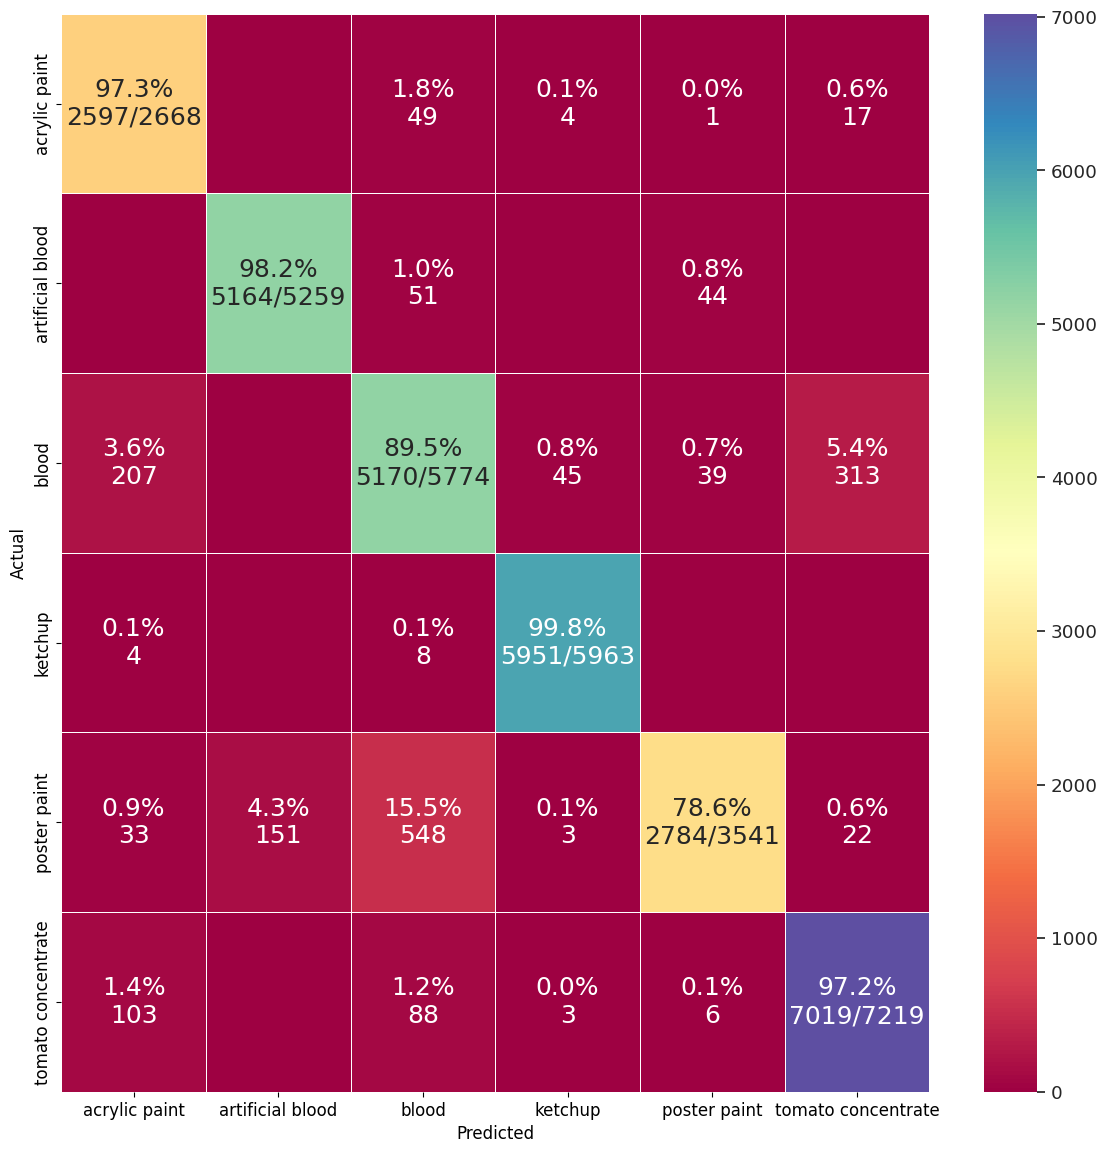

In [65]:
## Writing Confusion Matrix
file_name = str(WS)+str(DLM)+str(k)+"_Confusion_Matrix_Fast_3D_CNN_with_biggest_font.png"
cm, annot = Conf_Mat(Te_Pred, TeC, target_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(14,14))
sns.set(font_scale=1.2)
sns.heatmap(cm, cmap= "Spectral", annot=annot, fmt='', ax=ax, linewidths=0.6, annot_kws={"size": 18})
plt.savefig(file_name, dpi=500)
files.download(file_name)

In [ ]:
## Hybrid 3D/2D CNN Model
input_layer = Input((WS, WS, k, 1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
##conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 1), activation='relu')(conv_layer3)
## Conv3D with kernel_size=(3, 3, 1) can be used as well instead to reshape and Con2D.
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation = 'relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units = 128, activation = 'relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units = Num_Classes, activation = 'softmax')(dense_layer2)
# Define the Model with Input and Output Layers
model = Model(inputs = input_layer, outputs = output_layer)
model.summary()
## Compiling Hybrid CNN
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
## Fit the Model
start = time.time()
history2 = model.fit(x = Tr, y = TrC, batch_size = 256, epochs = 10, validation_data = (Va, VaC))
end = time.time()
Tr_Time = end - start
## Prediction Model
start = time.time()
Te_Pred = model.predict(Te)
end = time.time()
Te_Time = end - start
## Prediction and Computing the Accuacy
classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, Te_Pred)
print(classification)
## Writing Results in CSV File
file_name = str(WS)+str(DLM)+str(k)+"_Classification_Report.csv"
CSV_file = CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa)
files.download(file_name)
## Writing Confusion Matrix
file_name = str(WS)+str(DLM)+str(k)+"_Confusion_Matrix.png"
cm, annot = Conf_Mat(Te_Pred, TeC, target_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, cmap= "Spectral", annot=annot, fmt='', ax=ax, linewidths=0.5)
plt.savefig(file_name, dpi=500)
files.download(file_name)
## Predicted Ground Truths
outputs = GT_Plot(RDHSI, GT, model, WS)
file_name = str(HSID)+str(WS)+"_Ground_Truths_Hybrid.png"
plt.figure(figsize=(10, 10))
plt.imshow(outputs, cmap='nipy_spectral')
#plt.colorbar()
plt.axis('off')
plt.savefig(file_name, dpi=500)
files.download(file_name)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 9, 9, 15, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_8 (Conv3D)                    │ (None, 7, 7, 9, 8)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_9 (Conv3D)                    │ (None, 5, 5, 5, 16)         │           5,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 3, 3, 3, 32)         │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 3, 3, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 1, 1, 64)            │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,943 (491.96 KB)

 Trainable params: 125,943 (491.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 670ms/step - accuracy: 0.2817 - loss: 1.8233 - val_accuracy: 0.5935 - val_loss: 1.1205
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5714 - loss: 1.1148 - val_accuracy: 0.6686 - val_loss: 0.7630
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6601 - loss: 0.8041 - val_accuracy: 0.7651 - val_loss: 0.6047
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7401 - loss: 0.6310 - val_accuracy: 0.8077 - val_loss: 0.5089
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8105 - loss: 0.4929 - val_accuracy: 0.8663 - val_loss: 0.3891
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8423 - loss: 0.4049 - val_accuracy: 0.8846 - val_loss: 0.2934
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8708 - loss: 0.3313 - val_accuracy: 0.9278 - val_loss: 0.2104
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9221 - loss: 0.2306 - val_accuracy: 0.9509 - val_loss: 0.15

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

In [ ]:
## Writing Confusion Matrix
file_name = str(WS)+str(DLM)+str(k)+"_Confusion_Matrix_with_biggest_font.png"
cm, annot = Conf_Mat(Te_Pred, TeC, target_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(14,14))
sns.set(font_scale=1.2)
sns.heatmap(cm, cmap= "Spectral", annot=annot, fmt='', ax=ax, linewidths=0.6, annot_kws={"size": 18})
plt.savefig(file_name, dpi=500)
files.download(file_name)

In [ ]:
## Loss and Accuracy
plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 14})
plt.grid()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
#plt.title(str(HSID)+'_Loss')
plt.legend(['Tr-3-D','Val-3-D', 'Tr-Hybrid','Val-Hybrid'], loc='upper right')
plt.savefig(str(HSID)+"_loss_curve.png")
plt.show()
files.download(str(HSID)+"_loss_curve.png")

plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
#plt.title(str(HSID)+'_Accuracy')
plt.legend(['Tr-3-D','Val-3-D', 'Tr-Hybrid','Val-Hybrid'], loc='lower right')
plt.savefig(str(HSID)+"_acc_curve.png")
plt.show()
files.download(str(HSID)+"_acc_curve.png")